https://www.bts.gov/geography/geospatial-portal/electric-vehicle-public-charging-stations-united-states-2019
https://data-usdot.opendata.arcgis.com/datasets/usdot::alternative-fueling-stations/about
https://developer.nrel.gov/docs/transportation/alt-fuel-stations-v1/all/#response-fields

In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)

import numpy as np
#from pandasql import sqldf
import matplotlib.pyplot as plt
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon
import plotly.express as px
import json

In [2]:
%ls

230/                              data 230 project eda.ipynb
Alternative_Fueling_Stations.csv


# SHP

In [155]:
shp = gpd.read_file('./Alternative_Fueling_Stations/Alternative_Fueling_Stations.shp')
shp = shp.query(f'OBJECTID not in {[31667, 31668, 31681, 44101, 72751, 75209, 75214, 75915]} ')

In [193]:
# geometry = [Point(xy) for xy in zip(shp.longitude, shp.latitude)]
# shp['geometry'] = geometry
# shp.drop(['latitude','longitude'], axis = 1, inplace=True)

In [158]:

crs = {'init': 'epsg:4326'}
shp_locs = gpd.GeoDataFrame(shp, crs=crs, geometry=geometry)

/Users/tonc/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


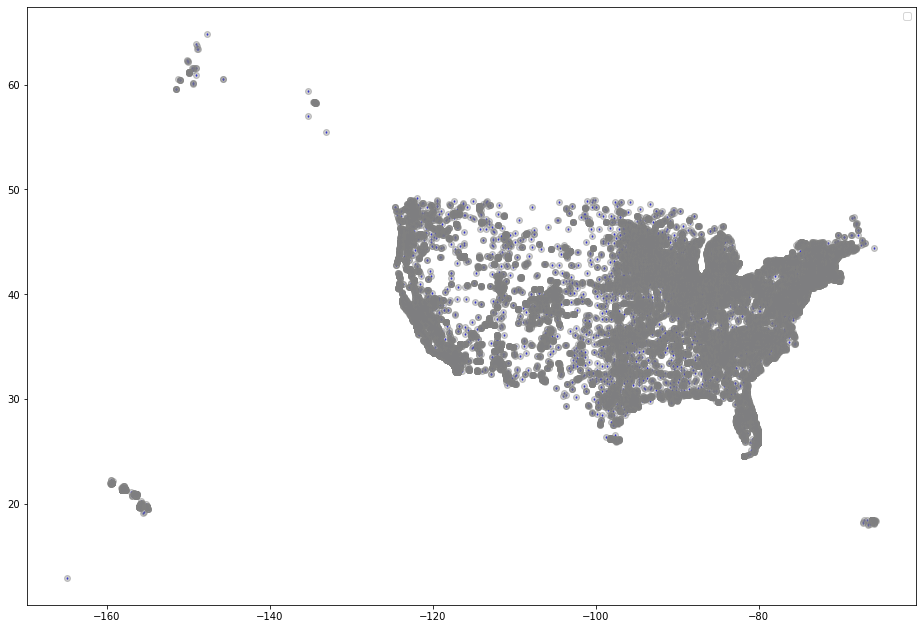

In [192]:
fig, ax = plt.subplots(figsize = (20,11))
shp.geometry.plot(marker='d', color='blue', markersize=1, ax=ax)
shp.plot(color='grey', ax=ax, alpha = 0.4)
# mosquito_locs[mosquito_locs['WnvPresent']==0].geometry.plot(marker='^', color = 'yellow', ax = ax, label = 'WNV-', alpha=.5, markersize = 75 )
# mosquito_locs[mosquito_locs['WnvPresent']==1].geometry.plot(marker='o', color = 'red', ax = ax, label = 'WNV+', alpha = .5, markersize = 10)
# at first glance, it looks as though WNV- mosquitos were found alongside WNV+ mosquitos everytime a WNV+ mosquito was found
    #however, there are lots of instances where WNV- mosquitos were found with WNV+ mosquitos
plt.legend()

In [218]:
data.columns

Index(['X', 'Y', 'OBJECTID', 'access_code', 'access_days_time',
       'date_last_confirmed', 'fuel_type_code', 'groups_with_access_code',
       'open_date', 'status_code', 'station_name', 'station_phone',
       'updated_at', 'geocode_status', 'city', 'state', 'street_address',
       'zip', 'country', 'ev_connector_types', 'ev_level2_evse_num',
       'ev_network', 'ev_network_web', 'ev_workplace_charging',
       'ev_network_ids_station', 'ev_network_ids_posts', 'longitude',
       'latitude'],
      dtype='object')

# CSV

In [3]:
data = pd.read_csv("Alternative_Fueling_Stations.csv")\
         .drop(['groups_with_access_code_fr','id'],axis=1)

print(f'original shape of data: {data.shape}')

missing_percentage = (data.isnull().sum() / len(data)) * 100
columns_to_drop = missing_percentage[missing_percentage > 60].index.tolist()
data.drop(columns=columns_to_drop, inplace=True)

print(f'after dropping variables with >= 60% missing values: {data.shape}')


/var/folders/y6/5s3fdvvn5fsfcckcz5fxgrn80000gn/T/ipykernel_43724/850834194.py:1: DtypeWarning: Columns (27,31,32,33,36,39,46,51,52,53,54,55,59,60,61,62,64,66,73,74) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("Alternative_Fueling_Stations.csv")\


original shape of data: (77419, 77)
after dropping variables with >= 60% missing values: (77419, 28)


In [4]:
def return_unique_vals(col):
    return data[col].unique().tolist()

def perc_missing(col):
    return round((data[col].isnull().sum() / len(data[col])) * 100,2)


#return_unique_vals('expected_date')

def jaccard_similarity(column1, column2):
    set1 = set(column1.dropna())
    set2 = set(column2.dropna())
    
    # Calculate Jaccard similarity
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    
    if union == 0:
        return 0  # Avoid division by zero
    else:
        return intersection / union

# Calculate Jaccard similarity between 'Column1' and 'Column2'
similarity_percentage = jaccard_similarity(data['X'], data['longitude']) * 100

print(f"Jaccard Similarity Percentage: {similarity_percentage:.2f}%")

similarity_percentage = jaccard_similarity(data['Y'], data['latitude']) * 100

print(f"Jaccard Similarity Percentage: {similarity_percentage:.2f}%")

Jaccard Similarity Percentage: 64.55%
Jaccard Similarity Percentage: 28.20%


In [5]:
data = pd.read_csv("Alternative_Fueling_Stations.csv",low_memory=False)\
         .drop(['groups_with_access_code_fr','id'],axis=1)
data['open_date'] = pd.to_datetime(data['open_date'])
data['open_date_date'] = pd.to_datetime(data['open_date'].dt.date)
data['open_date_year'] = data['open_date'].dt.year


In [6]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


text = data[['station_name']].dropna()['station_name'].values.tolist()
text2 = data.dropna()['city'].values


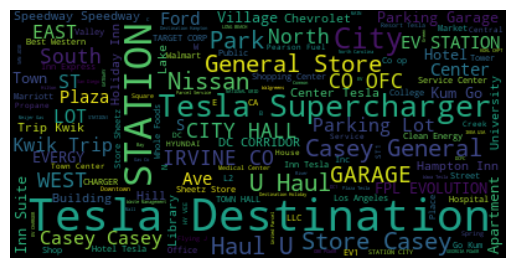

In [7]:

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(' '.join(text))

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Geojson

In [41]:
def df_to_geojson(df, properties, lat='latitude', lon='longitude'):
    """
    Turn a dataframe containing point data into a geojson formatted python dictionary
    
    df : the dataframe to convert to geojson
    properties : a list of columns in the dataframe to turn into geojson feature properties
    lat : the name of the column in the dataframe that contains latitude data
    lon : the name of the column in the dataframe that contains longitude data
    """
    
    # create a new python dict to contain our geojson data, using geojson format
    geojson = {'type':'FeatureCollection', 'features':[]}

    # loop through each row in the dataframe and convert each row to geojson format
    for _, row in df.iterrows():
        # create a feature template to fill in
        feature = {'type':'Feature',
                   'properties':{},
                   'geometry':{'type':'Point',
                               'coordinates':[]}}

        # fill in the coordinates
        feature['geometry']['coordinates'] = [row[lon],row[lat]]

        # for each column, get the value and add it as a new feature property
        for prop in properties:
            feature['properties'][prop] = row[prop]
        
        # add this feature (aka, converted dataframe row) to the list of features inside our dict
        geojson['features'].append(feature)
    
    return geojson

In [43]:
useful_columns = ['fuel_type_code', 'groups_with_access_code','status_code','geocode_status','state','ev_connector_types','ev_network', 'ev_network_web']
geojson_dict = df_to_geojson(data, properties=useful_columns)
geojson_str = json.dumps(geojson_dict, indent=2)

In [46]:
from geojson import Point, Feature, FeatureCollection, dump

# save the geojson result to a file
with open('ev_charge.geojson', 'w') as f:
   dump(geojson_str, f)
    
# how many features did we save to the geojson file?
print('{} geotagged features saved to file'.format(len(geojson_dict['features'])))

77419 geotagged features saved to file


In [74]:
import geojson

with open("ev_charge.geojson") as f:
    geojson = geojson.load(f)

## Animation

In [65]:
import plotly.graph_objects as go


state_city_stations = data.groupby(['city'])[['latitude','longitude']].median().reset_index()\
    .merge(data.groupby(['city']).size().to_frame("count_stations"), left_on = "city",right_on="city")\
    .sort_values('count_stations',ascending=False).reset_index().drop('index',axis=1)
state_city_stations['city'] = [i.title() for i in state_city_stations['city']]

state_city_stations['text'] = [str(i) + '<br>stations ' for i in state_city_stations['count_stations'] ]

state_city_stations

,city,latitude,longitude,count_stations,text
0,Los Angeles,34.059422,-118.333892,1850,1850<br>stations
1,San Diego,32.803323,-117.160126,797,797<br>stations
2,Atlanta,33.787208,-84.388117,697,697<br>stations
3,Irvine,33.662986,-117.766763,677,677<br>stations
4,Austin,30.275233,-97.733978,670,670<br>stations
...,...,...,...,...,...
8227,Lambertville,40.365828,-74.945080,1,1<br>stations
8228,Lamont,30.472350,-83.892260,1,1<br>stations
8229,Landrum,35.175185,-82.189139,1,1<br>stations
8230,Laotto,41.280426,-85.183956,1,1<br>stations


In [69]:
import sklearn
from sklearn.preprocessing import MinMaxScaler
chart_data = state_city_stations.rename(columns={'latitude':'lat','longitude':'lon'})
scaler = MinMaxScaler()
chart_data[['count_stations_scaled']] = scaler.fit_transform(chart_data[['count_stations']])

In [43]:

limits = [(1,2),(3,220),(221,10636)]
colors = ["royalblue","crimson","lightseagreen"]
cities = []
scale = 30

fig = go.Figure()

for i in range(len(limits)):
    lim = limits[i]
    df_sub = state_city_stations[lim[0]:lim[1]]
    fig.add_trace(go.Scattergeo(
        locationmode = 'USA-states',
        lon = df_sub['longitude'],
        lat = df_sub['latitude'],
        text = df_sub['text'],
        marker = dict(
            size = df_sub['count_stations']/scale,
            color = colors[i],
            line_color='rgb(40,40,40)',
            line_width=0.5,
            sizemode = 'area'
        ),
        name = '{0} - {1}'.format(lim[0],lim[1])))

fig.update_layout(
        title_text = '2023 US city charging stations <br>(Click legend to toggle traces)',
        showlegend = True,
        geo = dict(
            scope = 'usa',
            landcolor = 'rgb(217, 217, 217)',
        )
    )

fig.show()

In [41]:
fig = px.scatter_mapbox(state_city_stations, 
                    lat="latitude", 
                    lon="longitude", 
                    size="count_stations",
                    #hover_data=["ev_network","station_name","station_phone","fuel_type_code",'ev_connector_types','open_date_date'],
                    zoom = 3, size_max=15)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

In [54]:
pie_df = data.groupby('fuel_type_code').size().to_frame('size').reset_index()
pie_df

,fuel_type_code,size
0,BD,1694
1,CNG,1403
2,E85,4460
3,ELEC,66143
4,HY,125
5,LNG,132
6,LPG,2855
7,RD,607


In [64]:
col = "fuel_type_code"
col2 = "access_code"
for i in [col,col2]:
    pie_df = data.groupby(i).size().to_frame('size').reset_index()

    fig = px.pie(pie_df, values="size", names = i,
                    height=300, width=300)
    fig.update_layout(margin=dict(l=20, r=20, t=30, b=0),showlegend = True,)
    display(fig)

In [73]:
chart_data = pd.DataFrame(
   np.random.randn(1000, 2) / [50, 50] + [37.76, -122.4],
   columns=['lat', 'lon'])

pdk.Deck(
    map_style=None,
    initial_view_state=pdk.ViewState(
        latitude=37.76,
        longitude=-122.4,
        zoom=11,
        pitch=50,
    ),
    layers=[
        pdk.Layer(
           'HexagonLayer',
           data=chart_data,
           get_position='[lon, lat]',
           radius=200,
           elevation_scale=4,
           elevation_range=[0, 1000],
           pickable=True,
           extruded=True,
        ),
        pdk.Layer(
            'ScatterplotLayer',
            data=chart_data,
            get_position='[lon, lat]',
            get_color='[200, 30, 0, 160]',
            get_radius=200,
        ),
    ],
)

{
  "initialViewState": {
    "latitude": 37.76,
    "longitude": -122.4,
    "pitch": 50,
    "zoom": 11
  },
  "layers": [
    {
      "@@type": "HexagonLayer",
      "data": [
        {
          "lat": 37.782047175273576,
          "lon": -122.44875419139242
        },
        {
          "lat": 37.72499787737026,
          "lon": -122.38671140376601
        },
        {
          "lat": 37.762070147803044,
          "lon": -122.3975171597207
        },
        {
          "lat": 37.76563948425589,
          "lon": -122.37902014150687
        },
        {
          "lat": 37.74823243572258,
          "lon": -122.40860947318363
        },
        {
          "lat": 37.754934912408544,
          "lon": -122.37660207738676
        },
        {
          "lat": 37.75945091019194,
          "lon": -122.4064069748483
        },
        {
          "lat": 37.76509323226438,
          "lon": -122.44106743191912
        },
        {
          "lat": 37.75010603416057,
          "lon": -122.41992439030336
        },
        {
          "lat": 37.74748186736811,
          "lon": -122.39160138680101
        },
        {
          "lat": 37.73044134895318,
          "lon": -122.43585986396263
        },
        {
          "lat": 37.74332459980977,
          "lon": -122.42435665733248
        },
        {
          "lat": 37.74876615752735,
          "lon": -122.39572206154911
        },
        {
          "lat": 37.747021489886414,
          "lon": -122.4006864225439
        },
        {
          "lat": 37.75151832005386,
          "lon": -122.38761309906407
        },
        {
          "lat": 37.76941576731516,
          "lon": -122.3445250567912
        },
        {
          "lat": 37.75846692367867,
          "lon": -122.36875602865322
        },
        {
          "lat": 37.755635890770854,
          "lon": -122.4205733744315
        },
        {
          "lat": 37.751368023506835,
          "lon": -122.40636655382892
        },
        {
          "lat": 37.77316457123715,
          "lon": -122.37122152853335
        },
        {
          "lat": 37.764282303072044,
          "lon": -122.40052611303764
        },
        {
          "lat": 37.74742446951754,
          "lon": -122.37492134992117
        },
        {
          "lat": 37.76706795206532,
          "lon": -122.44713474956535
        },
        {
          "lat": 37.738060109528476,
          "lon": -122.41487113250051
        },
        {
          "lat": 37.764282244903505,
          "lon": -122.4086514890312
        },
        {
          "lat": 37.789720098340226,
          "lon": -122.4173665506169
        },
        {
          "lat": 37.740374160560656,
          "lon": -122.41361880940387
        },
        {
          "lat": 37.75495423682512,
          "lon": -122.37708346494877
        },
        {
          "lat": 37.764114731733166,
          "lon": -122.43551147724683
        },
        {
          "lat": 37.77457870335446,
          "lon": -122.38743051907382
        },
        {
          "lat": 37.76589865582729,
          "lon": -122.40291954490463
        },
        {
          "lat": 37.752627697816465,
          "lon": -122.40755135366516
        },
        {
          "lat": 37.76412710295749,
          "lon": -122.39500314723412
        },
        {
          "lat": 37.735575707443466,
          "lon": -122.41947067209824
        },
        {
          "lat": 37.72780621884751,
          "lon": -122.40516419366219
        },
        {
          "lat": 37.724653727506876,
          "lon": -122.3829031432621
        },
        {
          "lat": 37.75069107112832,
          "lon": -122.38898660633586
        },
        {
          "lat": 37.769929693293605,
          "lon": -122.40009975125953
        },
        {
          "lat": 37.76640668323496,
          "lon": -122.40009875982837
        },
        {
          "lat": 37.756862901290596,
          "lon": -122.39403403969875
        },
        {
          "lat": 37.74781862879234,
      

In [76]:
data.groupby(['fuel_type_code','cng_has_rng','cng_renewable_source']).size()

fuel_type_code  cng_has_rng  cng_renewable_source
CNG             0.0          NONE                      3
                1.0          LANDFILL                 15
                             LIVESTOCK                 2
                             NONE                    398
                             SOLAR                     3
                             WASTEWATER                7
dtype: int64

In [80]:
data.groupby(['fuel_type_code','lng_has_rng','lng_vehicle_class','lng_renewable_source']).size()

fuel_type_code  lng_has_rng  lng_vehicle_class  lng_renewable_source
LNG             1.0          HD                 LIVESTOCK                1
                                                NONE                    42
dtype: int64

<Axes: ylabel='fuel_type_code'>

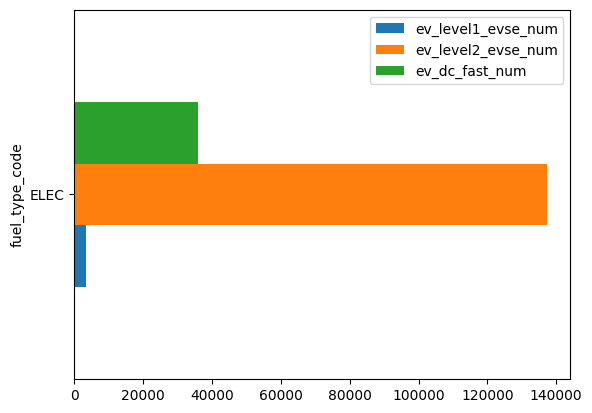

In [94]:
data.query('fuel_type_code == "ELEC"').groupby(['fuel_type_code']).agg({'ev_level1_evse_num':'sum',
                                      'ev_level2_evse_num':'sum',
                                      'ev_dc_fast_num':'sum'}).plot.barh()

In [95]:

facet_df = data.groupby(['city'])[['latitude','longitude']].median().reset_index()\
    .merge(data.groupby(['city']).size().to_frame("count_stations"), left_on = "city",right_on="city")\
    .sort_values('count_stations',ascending=False).reset_index().drop('index',axis=1)
facet_df['city'] = [i.title() for i in state_city_stations['city']]

facet_df

,city,latitude,longitude,count_stations
0,Los Angeles,34.059422,-118.333892,1850
1,San Diego,32.803323,-117.160126,797
2,Atlanta,33.787208,-84.388117,697
3,Irvine,33.662986,-117.766763,677
4,Austin,30.275233,-97.733978,670
...,...,...,...,...
8227,Lambertville,40.365828,-74.945080,1
8228,Lamont,30.472350,-83.892260,1
8229,Landrum,35.175185,-82.189139,1
8230,Laotto,41.280426,-85.183956,1


/var/folders/y6/5s3fdvvn5fsfcckcz5fxgrn80000gn/T/ipykernel_43724/112573408.py:3: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



<Axes: >

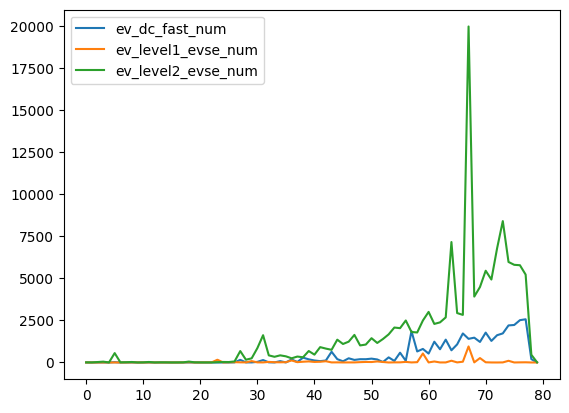

In [178]:
#.dt.to_period('Q')
elec = data.query('fuel_type_code == "ELEC"').sort_values('open_date')
elec_charge_df = elec.groupby(elec['open_date'].dt.to_period('Q'))[['ev_dc_fast_num','ev_level1_evse_num', 'ev_level2_evse_num']]\
    .sum().reset_index()
elec_charge_df.plot()

In [179]:
elec_charge_df_melt = elec_charge_df.melt(id_vars='open_date', value_vars=['ev_dc_fast_num','ev_level1_evse_num', 'ev_level2_evse_num'])
elec_charge_df_melt

,open_date,variable,value
0,1995Q3,ev_dc_fast_num,0.0
1,1996Q4,ev_dc_fast_num,0.0
2,1997Q3,ev_dc_fast_num,0.0
3,1998Q2,ev_dc_fast_num,0.0
4,1998Q3,ev_dc_fast_num,0.0
...,...,...,...
235,2023Q1,ev_level2_evse_num,5803.0
236,2023Q2,ev_level2_evse_num,5779.0
237,2023Q3,ev_level2_evse_num,5222.0
238,2023Q4,ev_level2_evse_num,460.0


In [132]:
px.line(elec_charge_df_melt, x = elec_charge_df_melt["open_date"].dt.strftime("%Y-%m"), y=elec_charge_df_melt['value'],color='variable',
                                title=f'Growth of charging stations between')

In [151]:
iso_df = elec_charge_df.set_index('open_date')

In [152]:
from sklearn.ensemble import IsolationForest
model_IF = IsolationForest(contamination=float(0.1),random_state=42)
model_IF.fit(iso_df)


IsolationForest(contamination=0.1, random_state=42)

In [167]:
iso_df['anomaly_scores'] = model_IF.decision_function(iso_df)
iso_df['anomaly'] = model_IF.predict(iso_df)

In [168]:
iso_df[['anomaly']].value_counts()

anomaly
 1         72
-1          8
Name: count, dtype: int64

<Axes: xlabel='open_date'>

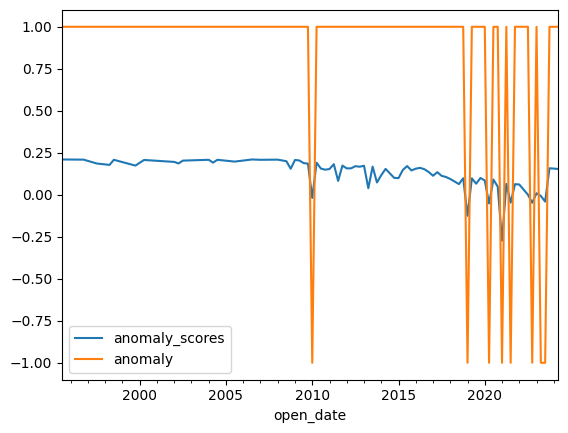

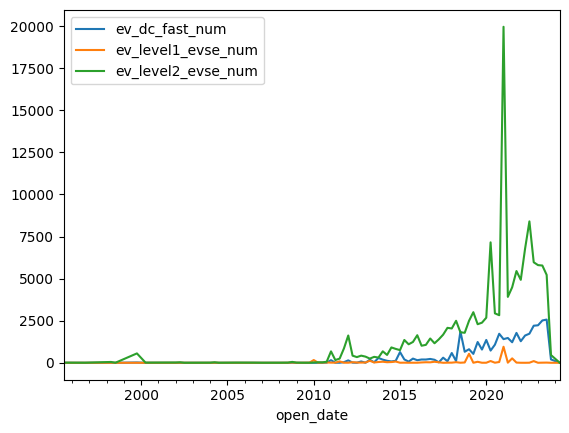

In [175]:
iso_df.filter(like="anomaly").plot()
iso_df[['ev_dc_fast_num','ev_level1_evse_num', 'ev_level2_evse_num']].plot()

In [259]:
iso_df = elec_charge_df.set_index('open_date')
from sklearn.ensemble import IsolationForest
model_IF = IsolationForest(contamination=float(0.1),random_state=42)
model_IF.fit(iso_df)

iso_df['anomaly_scores'] = model_IF.decision_function(iso_df)
iso_df['anomaly'] = model_IF.predict(iso_df.drop('anomaly_scores',axis=1))

In [184]:
anomaly_df = iso_df.filter(like="anomaly")
anomaly_df

,anomaly_scores,anomaly
open_date,,
1995Q3,0.226777,1
1996Q4,0.225948,1
1997Q3,0.222952,1
1998Q2,0.208485,1
1998Q3,0.225357,1
...,...,...
2023Q1,0.011189,1
2023Q2,-0.025463,-1
2023Q3,-0.047609,-1


In [212]:
outlier_dates = iso_df.sort_values("anomaly_scores")[iso_df['anomaly'] == -1].index
outlier_dates

/var/folders/y6/5s3fdvvn5fsfcckcz5fxgrn80000gn/T/ipykernel_43724/2769702777.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



PeriodIndex(['2021Q1', '2019Q1', '2022Q4', '2020Q2', '2021Q3', '2023Q3',
             '2023Q2', '2022Q3'],
            dtype='period[Q-DEC]', name='open_date')

In [216]:
iso_df.index = [i.strftime("%Y-%m") for i in iso_df.index]

AttributeError: 'str' object has no attribute 'strftime'

In [245]:
anomaly_dates = iso_df.sort_values("anomaly_scores").query('anomaly == -1')
non_anomaly_dates = iso_df.sort_values("anomaly_scores").query('anomaly == 1')

In [215]:
# obtain y value of anomalies to plot
y_values = [iso_df.loc[i]['value'] for i in outlier_dates]
fig.add_trace(go.Scatter(x=outlier_dates, y=y_values, mode = ‘markers’, name = ‘Anomaly’, marker=dict(color=’red’,size=10)))

SyntaxError: invalid character '‘' (U+2018) (1643184433.py, line 3)

In [225]:
def outlier_plot(data, outlier_method_name, x_var, y_var, 
                 xaxis_limits=[0,1], yaxis_limits=[0,1]):
    import seaborn as sns
    
    print(f'Outlier Method: {outlier_method_name}')
    
    # Create a dynamic title based on the method
    method = f'{outlier_method_name}_anomaly'
    
    # Print out key statistics
    print(f"Number of anomalous values {len(data[data['anomaly']==-1])}")
    print(f"Number of non anomalous values  {len(data[data['anomaly']== 1])}")
    print(f'Total Number of Values: {len(data)}')
    
    # Create the chart using seaborn
    g = sns.FacetGrid(data, col='anomaly', height=4, hue='anomaly', hue_order=[1,-1])
    g.map(sns.scatterplot, x_var, y_var)
    g.fig.suptitle(f'Outlier Method: {outlier_method_name}', y=1.10, fontweight='bold')
    g.set(xlim=xaxis_limits, ylim=yaxis_limits)
    axes = g.axes.flatten()
    axes[0].set_title(f"Outliers\n{len(data[data['anomaly']== -1])} points")
    axes[1].set_title(f"Inliers\n {len(data[data['anomaly']==  1])} points")
    return g

Outlier Method: Isolation Forest
Number of anomalous values 8
Number of non anomalous values  72
Total Number of Values: 80


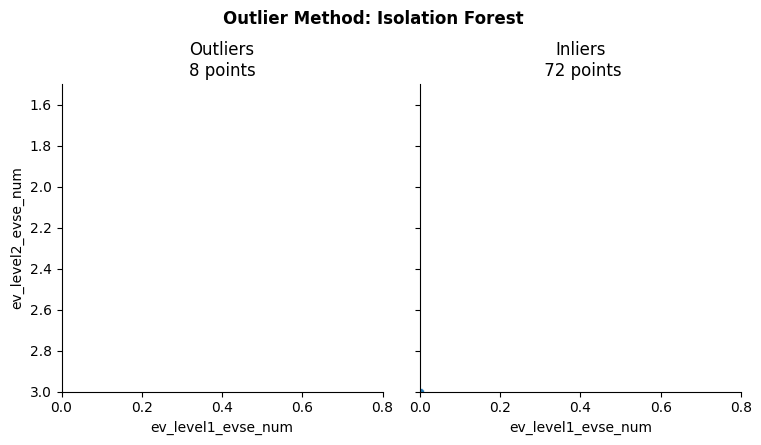

In [226]:
outlier_plot(iso_df, 'Isolation Forest', 'ev_level1_evse_num', 'ev_level2_evse_num', [0, 0.8], [3, 1.5])


Text(0.5, 1.0, 'Inliers\n 72 points')

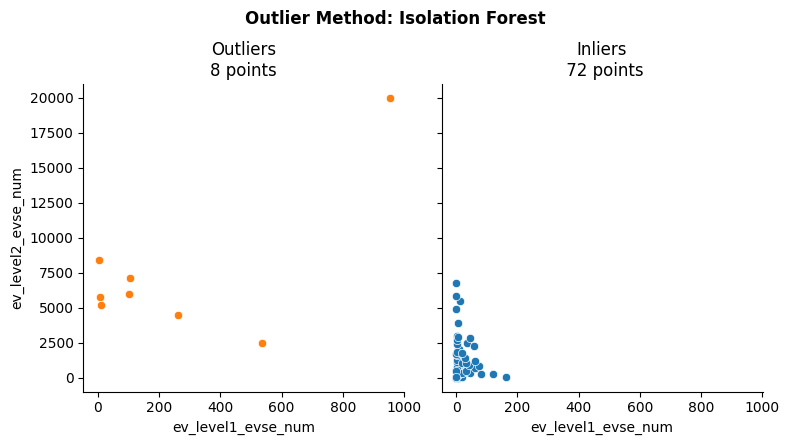

In [235]:
import seaborn as sns
xaxis_limits=[0,1]
yaxis_limits=[0,1]
g = sns.FacetGrid(iso_df, col='anomaly', height=4, hue='anomaly', hue_order=[1,-1])
g.map(sns.scatterplot, 'ev_level1_evse_num', 'ev_level2_evse_num')
g.fig.suptitle(f'Outlier Method: Isolation Forest', y=1.10, fontweight='bold')
#g.set(xlim=xaxis_limits, ylim=yaxis_limits)
axes = g.axes.flatten()
axes[0].set_title(f"Outliers\n{len(iso_df[iso_df['anomaly']== -1])} points")
axes[1].set_title(f"Inliers\n {len(iso_df[iso_df['anomaly']==  1])} points")

In [239]:
anomaly_dates.columns

Index(['ev_dc_fast_num', 'ev_level1_evse_num', 'ev_level2_evse_num',
       'anomaly_scores', 'anomaly'],
      dtype='object')

Text(0.5, 0, 'ev_level2_evse_num')

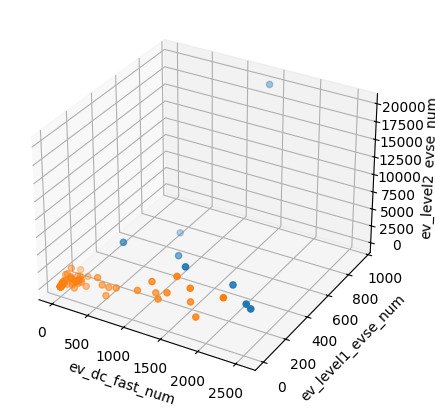

In [246]:
plt.figure(figsize = (5, 5))
plot_axes = plt.axes(projection = '3d')
plot_axes.scatter3D(anomaly_dates['ev_dc_fast_num'],
                   anomaly_dates['ev_level1_evse_num'],
                   anomaly_dates['ev_level2_evse_num'])
plot_axes.scatter3D(non_anomaly_dates['ev_dc_fast_num'],
                    non_anomaly_dates['ev_level1_evse_num'],
                    non_anomaly_dates['ev_level2_evse_num'])
plot_axes.set_xlabel('ev_dc_fast_num')
plot_axes.set_ylabel('ev_level1_evse_num')
plot_axes.set_zlabel('ev_level2_evse_num')

Text(0.5, 0, 'ev_level2_evse_num')

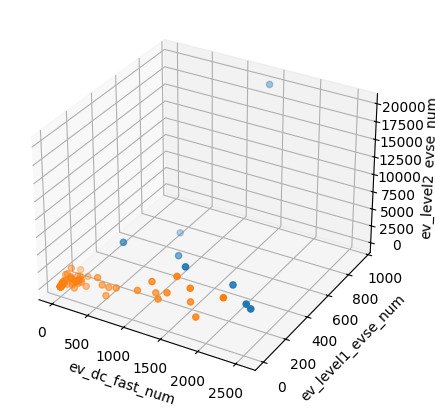

In [258]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.scatter(anomaly_dates['ev_dc_fast_num'],
                anomaly_dates['ev_level1_evse_num'],
                anomaly_dates['ev_level2_evse_num'])
ax.scatter(non_anomaly_dates['ev_dc_fast_num'],
                    non_anomaly_dates['ev_level1_evse_num'],
                    non_anomaly_dates['ev_level2_evse_num'])
ax.set_xlabel('ev_dc_fast_num')
ax.set_ylabel('ev_level1_evse_num')
ax.set_zlabel('ev_level2_evse_num')